In [1]:
%%capture
!pip install shap

In [2]:
import torch
import shap
import os
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr

if 'notebooks' in os.getcwd():
    os.chdir("..")

import util

Prepare data

In [3]:
ds = xr.open_dataset("data_working/westmort.nc")
# Apply smoothing
ds["mort_ewma"] = xr.apply_ufunc(
    util.manip.numpy_ewma_vectorized,
    ds.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    kwargs=dict(window=3)
)
# Calculate total basal area based on all the genus rasters
# TODO maybe put this in the snakemake pipeline so we have reproducibility
ba_vars = ["abies", "picea", "populus", "tsuga", "pseudotsuga"]
ds["forest_ba"] = ds[ba_vars].to_stacked_array("band", sample_dims=["x", "y", "time"]).sum(dim="band")

# Smaller window since we don't need the 5th timestep for loss
# calculation.
window = dict(x=[8, False], y=[8, False], time=[4, False])
wds = util.datasets.WindowXarrayDataset(ds, window, mask="mort_ewma")

In [14]:
# This is really slow but we only care about getting 1000 windows so nbd
input_bands = ["fire", "mort_ewma", "prcp", "elev", "treecover", "forest_ba", "vp", "tmin"]
def yield_window(patch):
    return patch[input_bands]\
        .to_stacked_array("band", sample_dims=["x", "y", "time"])\
        .transpose("time", "band", ...)\
        .values
    
background_sample = np.random.choice(len(wds), 1000, replace=False)
background = np.stack([yield_window(wds[i]) for i in background_sample])
background = torch.from_numpy(background)
print(background.shape)

torch.Size([1000, 4, 8, 8, 8])


Prepare model

In [15]:
input_channel = len(input_bands)
hidden_dim = 6
num_layers = 2
kernel = (3, 3)

m = util.convlstm.DamageConvLSTM(
    input_channel, 
    hidden_dim, 
    kernel, 
    num_layers, 
    batch_first=True,
    dropout=0.3
)

m.load_state_dict(torch.load("logs/convlstm_small_dropout__8_8_5__ewma__8band/model.pth", weights_only=True))
m.eval()

DamageConvLSTM(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(14, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (drop): Dropout(p=0.3, inplace=False)
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (drop): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (conv): Conv2d(6, 1, kernel_size=(1, 1), stride=(1, 1))
  (sigmoid): Sigmoid()
  (bn): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

SHAP only works for scalar outputs. Take the mean of the 8x8 output.

In [16]:
class ShapAdapter(torch.nn.Module):
    def __init__(self, m, *args, **kwargs):
        super(ShapAdapter, self).__init__(*args, **kwargs)
        self.base_model = m

    def forward(self, X):
        # Convert to logits and take mean
        out = self.base_model(X)
        out_logit = torch.log(out / (1 - out))
        dims = tuple(range(1, len(out_logit.shape)))
        return torch.mean(out_logit, dims).reshape(-1, 1)

sa = ShapAdapter(m)
test_out = sa(background)
print(test_out.shape)
print(torch.mean(test_out))

torch.Size([1000, 1])
tensor(-0.5915, grad_fn=<MeanBackward0>)


In [17]:
de = shap.GradientExplainer(sa, background)

In [18]:
values = de.shap_values(background)

In [19]:
print(values.shape)

(1000, 4, 8, 8, 8, 1)


In [20]:
# sum over time, x, and y to isolate channel effect
value_channel_sum = np.sum(values, axis=(1, 3, 4, 5))
print(value_channel_sum.shape)

(1000, 8)


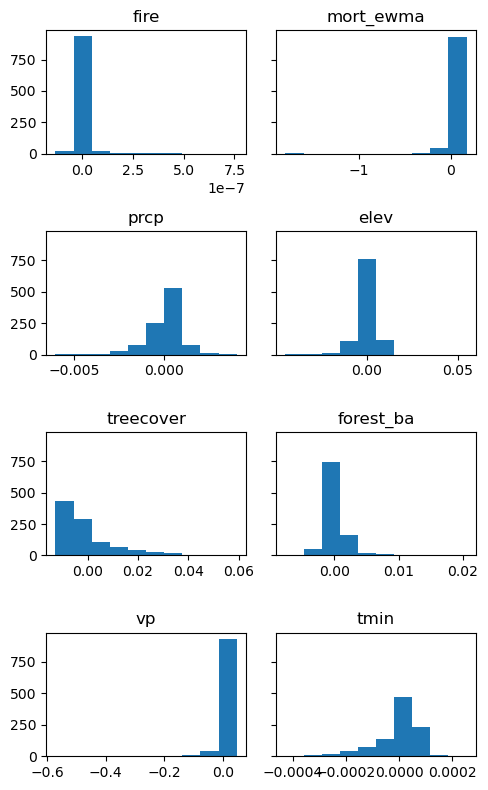

In [21]:
fig, axes = plt.subplots(4, 2, sharex=False, sharey=True, figsize=(5, 8))

for i, (ax, band) in enumerate(zip(axes.flatten(), input_bands)):
    ax.hist(value_channel_sum[:, i])
    ax.set_title(band)

fig.tight_layout()
plt.show()

In [22]:
site_bands = ["treecover", "forest_ba", "elev"]

is_site_param  = np.array(list(map(lambda x: x in site_bands, input_bands)))
not_site_param = ~is_site_param
mort_ewma_ind = input_bands.index("mort_ewma")

# since the mortality signal dominates the prediction, ignore it
is_site_param[mort_ewma_ind] = False
not_site_param[mort_ewma_ind] = False

site_effects  = np.abs(np.sum(values.take(is_site_param, axis=2).reshape(values.shape[0], -1), axis=1))
other_effects = np.abs(np.sum(values.take(not_site_param, axis=2).reshape(values.shape[0], -1), axis=1))
ewma_effects  = np.abs(np.sum(values.take([mort_ewma_ind], axis=2).reshape(values.shape[0], -1), axis=1))

print(site_effects.shape)
print(other_effects.shape)
print(ewma_effects.shape)

effect_stack = np.stack([site_effects, other_effects, ewma_effects])

(1000,)
(1000,)
(1000,)


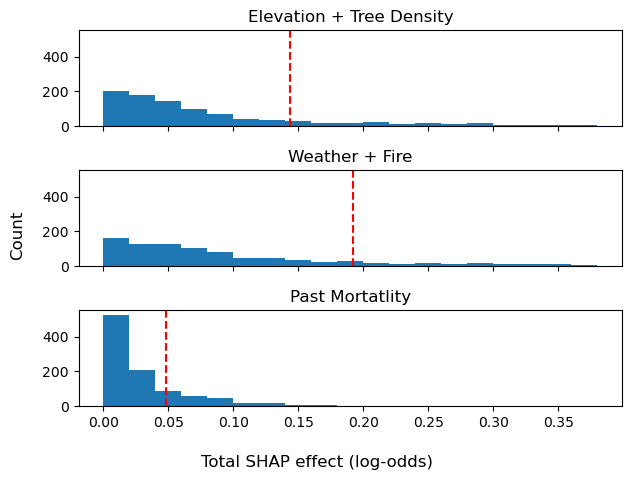

In [23]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)

bins = np.arange(0, 0.4, step=0.02)

for i, (e, name) in enumerate(zip(effect_stack, ("Elevation + Tree Density", "Weather + Fire", "Past Mortatlity"))):
    axes[i].hist(e, bins=bins)
    axes[i].axvline(x=np.mean(e), color="red", linestyle="--")
    axes[i].set_title(name)

fig.supxlabel("Total SHAP effect (log-odds)")
fig.supylabel("Count")
fig.tight_layout()
plt.show()